In [1]:
%matplotlib inline

# Training Data Summary

In [2]:
import math
import os
import re

from collections import namedtuple, Counter, OrderedDict
from glob import glob
from multiprocessing import Pool, freeze_support
from subprocess import run
from tempfile import TemporaryDirectory

import numpy as np
import scipy
import wfdb

from biosppy.signals.ecg import ecg
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from scipy.signal import resample
from tqdm.notebook import tqdm
from wfdb import processing

from util.sigproc import extract_ecg_features

## Initial Data

The [data for this Challenge](https://physionetchallenges.github.io/2020/#-data) comes from multiple sources:

1. Southeast University, China, including the data from the China Physiological Signal Challenge 2018
2. Centre for Cardiometabolic Risk Reduction in South-Asia (CARRS), India
3. A diverse population in the USA.

This full dataset has not been released yet.
The initial data provided is the public data used in the [China Physiological Signal Challenge in 2018 (CPSC2018)](http://2018.icbeb.org/).
It contains:

* 6,877 records (male: 3,699, female: 3,178)
* 12-lead ECG recordings ranging from 6 to 60 seconds
* Sampled at 500Hz
* Age, Diagnosis at the end of header file


In [3]:
record_names = tuple(sorted(fn.split(".hea")[0] for fn in glob("Training_WFDB/*.hea")))
num_records = len(record_names)
print("num records:", num_records)


num records: 6877


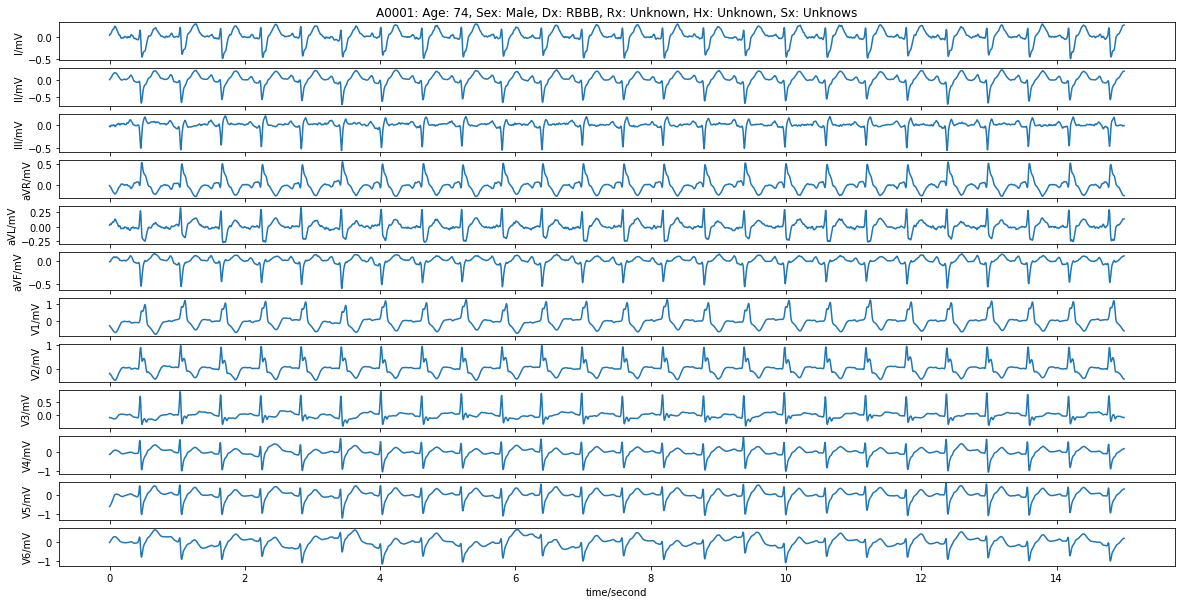

record_name: A0001
n_sig: 12
fs: 500
counter_freq: None
base_counter: None
sig_len: 7500
base_time: 00:00:05
base_date: None
comments: ['Age: 74', 'Sex: Male', 'Dx: RBBB', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknows']
sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
p_signal: [[ 0.028  0.007 -0.021 ... -0.112 -0.596 -0.016]
 [ 0.039  0.011 -0.028 ... -0.11  -0.59  -0.007]
 [ 0.045  0.015 -0.03  ... -0.108 -0.582  0.002]
 ...
 [ 0.258  0.248 -0.01  ...  0.194  0.307  0.213]
 [ 0.259  0.249 -0.01  ...  0.194  0.307  0.214]
 [ 0.259  0.25  -0.009 ...  0.195  0.307  0.214]]
d_signal: None
e_p_signal: None
e_d_signal: None
file_name: ['A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat', 'A0001.mat']
fmt: ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
samps_per_frame: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
skew: [None, None, None, None, None, N

In [4]:
# show what one record looks like
record = wfdb.rdrecord(record_names[0])
wfdb.plot_wfdb(
    record=record, figsize=(20,10),
    time_units="seconds", title="{}: {}".format(record.record_name, ", ".join(record.comments)))
for k, v in record.__dict__.items():
    print(f"{k}: {v}")

## Initial Data Distribution

In [5]:
Meta = namedtuple("Meta", ("duration", "age", "sex", "Dx", "sig_len"))
labels = ("Normal", "AF", "I-AVB", "LBBB", "RBBB", "PAC", "PVC", "STD", "STE")

def derive_meta(rn):
    r = wfdb.rdrecord(rn)
    key = r.record_name

    # data hygiene, check match challenge description
    assert len(r.p_signal) == r.sig_len, f"{key} sig_len mismatch"
    assert r.n_sig == 12, f"{key} n_sig not 12-lead"
    assert all(len(l) == r.n_sig for l in r.p_signal), f"{key} p_signal not 12-lead"
    assert r.fs == 500, f"{key} not 500Hz"
    assert r.sig_name == ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    assert r.fmt == ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
    assert r.samps_per_frame == [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    assert r.skew == [None, None, None, None, None, None, None, None, None, None, None, None]
    assert r.byte_offset == [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
    assert r.adc_gain == [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
    assert r.baseline == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    assert r.units == ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV']
    assert r.adc_res == [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    assert r.adc_zero == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    assert r.block_size == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # parse out age, sex, diagnosis from comments
    assert len(r.comments) == 6, f"{key} header comments invalid"
    raw_age, raw_sx, raw_dx, _rx, _hx, _sx = r.comments
    age_grp = re.search(r"^Age: (?P<age>.*)$", raw_age)
    assert age_grp is not None, f"{key} no age defined: {raw_age}"
    age = float(age_grp.group("age"))
    if math.isnan(age):
        age = -1

    sx_grp = re.search(r"^Sex: (?P<sx>.*)$", raw_sx)
    assert sx_grp is not None, f"{key} no sex defined: {raw_sx}"
    sex = sx_grp.group("sx")
    assert sex in ("Male", "Female"), f"{key} not male/female: {sex}"
    dx_grp = re.search(r"^Dx: (?P<dx>.*)$", raw_dx)
    assert dx_grp is not None, f"{key} no Dx defined: {raw_dx}"
    dx = dx_grp.group("dx").split(",")
    assert all(d in labels for d in dx), f"{key} label mismatch: {dx}"

    duration = r.sig_len/r.fs

    return key, Meta(duration, age, sex, dx, r.sig_len)


In [6]:
metas = {}
# single process approach
# for record_name in tqdm(record_names, desc="Record"):
#     key, meta = derive_meta(record_name)
#     metas[key] = meta

# multiprocess approach
try:
    procs = len(os.sched_getaffinity(0))
except:
    procs = 1

with tqdm(record_names, desc="Record") as t:
    with Pool(procs, initializer=tqdm.set_lock,
              initargs=(tqdm.get_lock(),)) as p:
        metas = dict(p.imap_unordered(derive_meta, t))


### ECG Signal Lengths

max sig_len 72000
min sig_len 3000
median sig_len 6000.0
mean sig_len 7974.042169550677
std sig_len 4978.556084918079
var sig_len 24786020.69067483


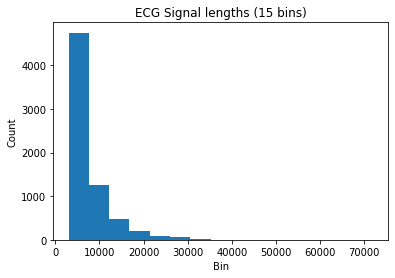

3000.0s: 4746 records
7600.0s: 1259 records
12200.0s: 466 records
16800.0s: 212 records
21400.0s: 95 records
26000.0s: 73 records
30600.0s: 9 records
35200.0s: 5 records
39800.0s: 2 records
44400.0s: 2 records
49000.0s: 2 records
53600.0s: 1 records
58200.0s: 2 records
62800.0s: 1 records
67400.0s: 2 records


In [7]:
lengths = [m.sig_len for m in metas.values()]

print("max sig_len", np.max(lengths))
print("min sig_len", np.min(lengths))
print("median sig_len", np.median(lengths))
print("mean sig_len", np.mean(lengths))
print("std sig_len", np.std(lengths))
print("var sig_len", np.var(lengths))

bins = 15
plt.title(f"ECG Signal lengths ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

count_vals, bin_vals, _ = plt.hist(lengths, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>5.1f}s: {:.0f} records".format(k, v))



### ECG Recording Duration

max duration 144.0
min duration 6.0
median duration 12.0
mean duration 15.948084339101351
std duration 9.95711216983616
var duration 99.14408276269934


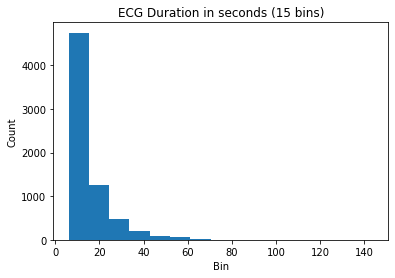

  6.0s: 4746 records
 15.2s: 1259 records
 24.4s: 466 records
 33.6s: 212 records
 42.8s: 95 records
 52.0s: 73 records
 61.2s: 9 records
 70.4s: 5 records
 79.6s: 2 records
 88.8s: 2 records
 98.0s: 2 records
107.2s: 1 records
116.4s: 2 records
125.6s: 1 records
134.8s: 2 records


In [8]:
durations = [m.duration for m in metas.values()]

print("max duration", np.max(durations))
print("min duration", np.min(durations))
print("median duration", np.median(durations))
print("mean duration", np.mean(durations))
print("std duration", np.std(durations))
print("var duration", np.var(durations))

bins = 15
plt.title(f"ECG Duration in seconds ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

count_vals, bin_vals, _ = plt.hist(durations, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>5.1f}s: {:.0f} records".format(k, v))

# for full resolution, fine grained
# counts = Counter(durations)
# x = list(counts.keys())
# y = list(counts.values())
# plt.scatter(x, y)

### ECG Recording Patient Age

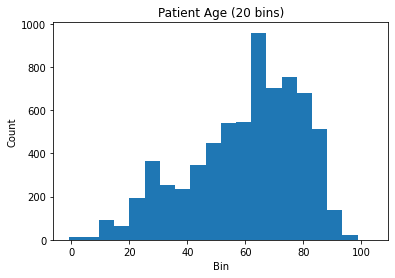

-1 yrs: 13 records
 4 yrs: 11 records
10 yrs: 91 records
15 yrs: 62 records
20 yrs: 192 records
25 yrs: 365 records
30 yrs: 254 records
36 yrs: 234 records
41 yrs: 348 records
46 yrs: 447 records
52 yrs: 542 records
57 yrs: 546 records
62 yrs: 959 records
67 yrs: 702 records
72 yrs: 755 records
78 yrs: 681 records
83 yrs: 513 records
88 yrs: 140 records
94 yrs: 21 records
99 yrs: 1 records


In [9]:
bins = 20
plt.title(f"Patient Age ({bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Count")

ages = [m.age for m in metas.values()]
count_vals, bin_vals, _ = plt.hist(ages, bins=bins)

plt.show()

for k, v in zip(bin_vals, count_vals):
    # plt.text(k, v, "{:.1f}s: {:.0f}".format(k, v))
    print("{:>2.0f} yrs: {:.0f} records".format(k, v))

# for full resolution, fine grained
# counts = Counter(ages)
# x = list(counts.keys())
# y = list(counts.values())
# plt.scatter(x, y)

### ECG Diagnosis Distribution

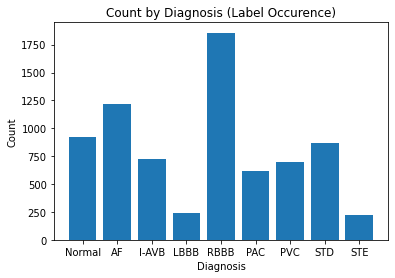

Label Occurences
Normal: (13.3%) 918 records
    AF: (17.8%) 1221 records
 I-AVB: (10.5%) 722 records
  LBBB: ( 3.4%) 236 records
  RBBB: (27.0%) 1857 records
   PAC: ( 9.0%) 616 records
   PVC: (10.2%) 700 records
   STD: (12.6%) 869 records
   STE: ( 3.2%) 220 records


In [10]:
flat_dx = [dx for m in metas.values() for dx in m.Dx]
dx_counter = Counter(flat_dx)

plt.title("Count by Diagnosis (Label Occurence)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.bar(labels, list(dx_counter[l] for l in labels))
bottom, top = plt.ylim()
plt.show()

print("Label Occurences")
for label in labels:
    pct = 100 * dx_counter[label] / num_records
    print("{:>6}: ({:>4.1f}%) {} records".format(label, pct, dx_counter[label]))

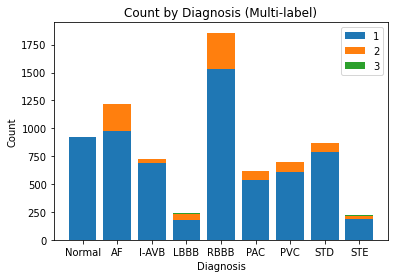

Multi-Label Occurences
           RBBB: (22.29%) 1533 records
             AF: (14.19%) 976 records
         Normal: (13.35%) 918 records
            STD: (11.40%) 784 records
          I-AVB: ( 9.98%) 686 records
            PVC: ( 8.83%) 607 records
            PAC: ( 7.75%) 533 records
            STE: ( 2.69%) 185 records
           LBBB: ( 2.60%) 179 records
       AF, RBBB: ( 2.50%) 172 records
      PAC, RBBB: ( 0.76%) 52 records
      PVC, RBBB: ( 0.74%) 51 records
        AF, STD: ( 0.44%) 30 records
       AF, LBBB: ( 0.38%) 26 records
      RBBB, STD: ( 0.29%) 20 records
       PVC, STD: ( 0.26%) 18 records
      RBBB, STE: ( 0.23%) 16 records
    I-AVB, RBBB: ( 0.15%) 10 records
      LBBB, PAC: ( 0.15%) 10 records
    I-AVB, LBBB: ( 0.12%) 8 records
        AF, PVC: ( 0.12%) 8 records
      LBBB, PVC: ( 0.09%) 6 records
       PAC, STD: ( 0.09%) 6 records
     I-AVB, STD: ( 0.09%) 6 records
     I-AVB, PVC: ( 0.07%) 5 records
     I-AVB, STE: ( 0.06%) 4 records
        AF,

In [11]:
plt.title("Count by Diagnosis (Multi-label)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")

prv_count = [0,] * len(labels)
plts = {}
for i in range(1, len(labels)):
    nested_dx = [dx for m in metas.values() for dx in m.Dx if len(m.Dx) == i]
    if not nested_dx:
        continue
    dx_counter = Counter(nested_dx)
    count = list(dx_counter[l] for l in labels)
    plts[i] = plt.bar(labels, count, bottom=prv_count)
    prv_count = list(sum(c) for c in zip(prv_count, count))

plt.ylim(bottom, top)
plt.legend(plts.values(), plts.keys())
plt.show()

dx_counter = Counter([", ".join(sorted(m.Dx)) for m in metas.values()])
print("Multi-Label Occurences")
for key, count in sorted(dx_counter.items(), key=lambda i: i[1], reverse=True):
    pct = 100 * count / num_records
    print("{:>15}: ({:>5.2f}%) {} records".format(key, pct, count))


## WFDB QRS Detection Algorithms

The WFDB library provides helper processors (like [XQRS](https://wfdb.readthedocs.io/en/latest/processing.html#wfdb.processing.XQRS)) for generating annotations. 

In [12]:
wfdb.show_ann_labels()
wfdb.show_ann_classes()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [13]:
def xqrs_detect(record_name):
    sig_qrs_inds = []
    for channel in range(12):
        sig, fields = wfdb.rdsamp(record_name, channels=[channel])

        sig_qrs_inds.append(processing.xqrs_detect(
            sig=sig[:,0], sampfrom=0, sampto="end", fs=fields["fs"],
            learn=False, verbose=False))

    avg_sig_qrs_inds = np.array(
        [int(sum(e) / len(e)) for e in zip(
            *[a for a in sig_qrs_inds if len(a)])])
    return sig_qrs_inds, avg_sig_qrs_inds


In [14]:
record = wfdb.rdrecord(record_names[0])
sig_ann, sig_avg_ann = xqrs_detect(record_names[0])

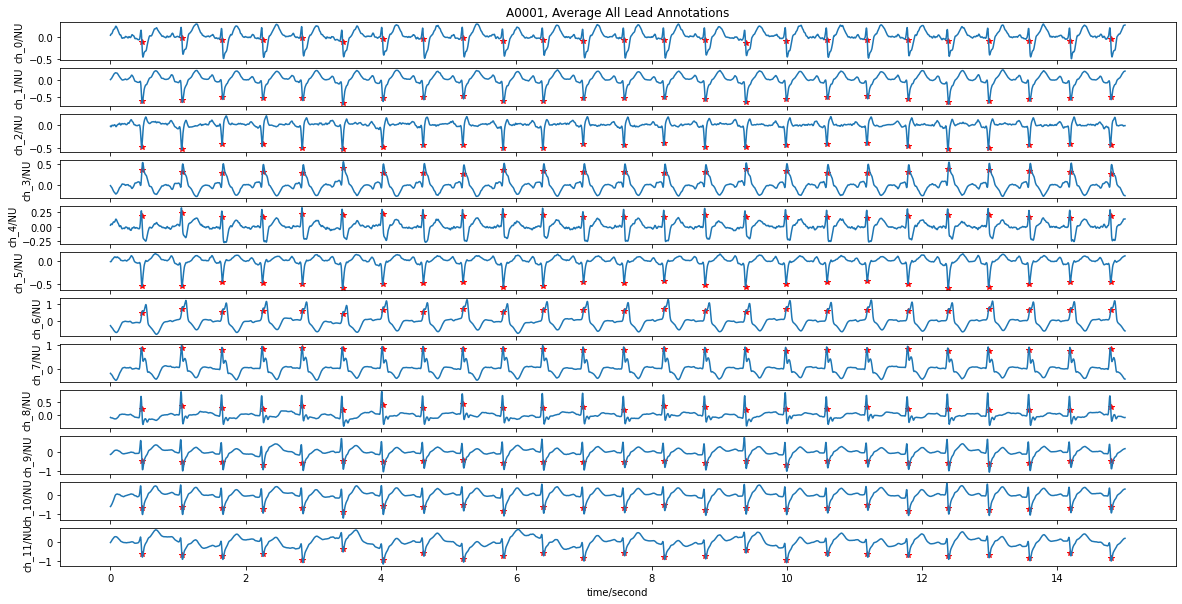

In [15]:
wfdb.plot_items(
    signal=record.p_signal,
    ann_samp=[sig_avg_ann,] * 12,
    fs = record.fs,
    time_units="seconds",
    figsize=(20,10),
    title="{}, Average All Lead Annotations".format(record.record_name))

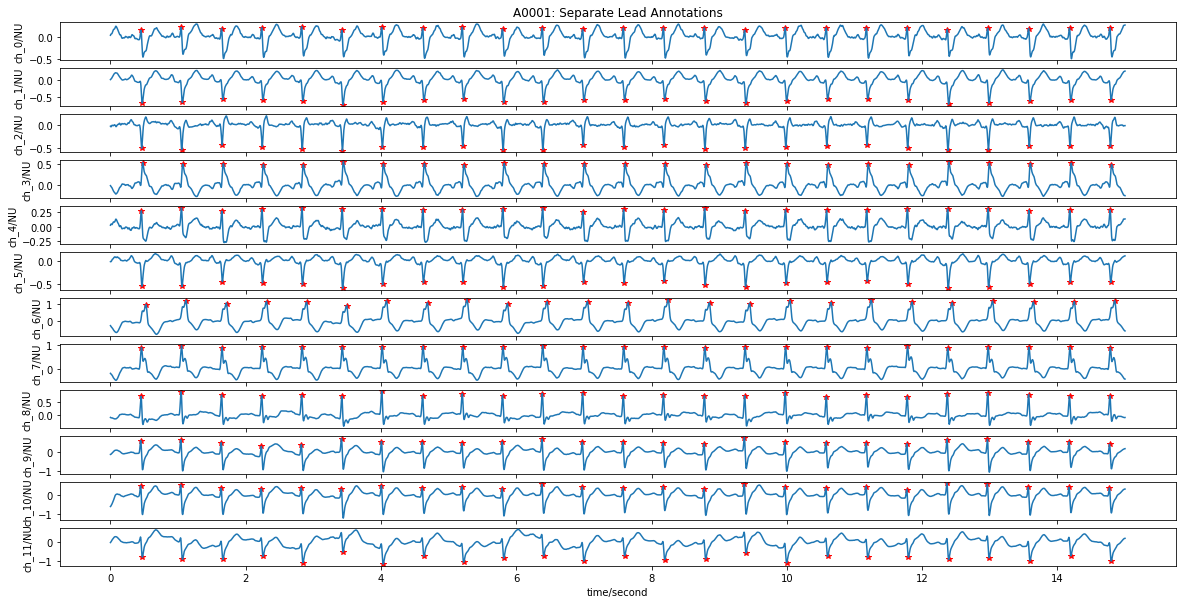

In [16]:
wfdb.plot_items(
    signal=record.p_signal,
    ann_samp=sig_ann,
    fs = record.fs,
    time_units="seconds",
    figsize=(20,10),
    title="{}: Separate Lead Annotations".format(record.record_name))

## Visualizing the ECGPUWAVE annotation output

Requires the ecgpuwave binary to be built and installed in the user's path.

Writing file A0001.mat with 24 empty leading bytes


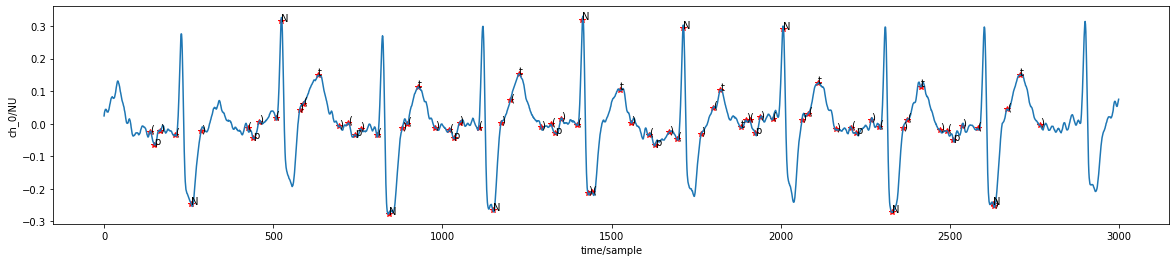

In [42]:
signal = 4
sampto = 3000

r = wfdb.rdrecord(record_names[0], sampto=sampto)

with TemporaryDirectory() as temp_dir:
    r.adc(inplace=True)
    r.wrsamp(write_dir=temp_dir)
    # Call ecgpuwave (requires it to be in path)
    r_pth = os.path.join(temp_dir, r.record_name)
    run(
        f"ecgpuwave -r {r.record_name} -a atr -s {signal}",
        cwd=temp_dir,
        shell=True,
        check=True,
    )
    ann = wfdb.io.rdann(r_pth, "atr", sampto=sampto)
    
# wfdb.plot.plot_wfdb(
#     record=r, annotation=ann, plot_sym=True, figsize=(10,4))

r.dac(inplace=True)
wfdb.plot_items(
    signal=r.p_signal[:,signal],
    ann_samp=[ann.sample,],
    ann_sym=[ann.symbol,],
    fs=r.fs,
    figsize=(20,4)
)

## Annotation comparitor

(Currently unused)

In [ ]:
comparitor = processing.Comparitor(sig_ann[0], sig_ann[7], int(0.1 * record.fs), record.p_signal)
comparitor.compare()
comparitor.print_summary()
comparitor.plot(figsize=(20,8))

## Fourier Transformation

Applying the Fourier transformation on the ECG signals as a method of feature extraction


In [ ]:
# Use a Hann window to ensure signal starts and ends with a zero
# scipy.signal.hann()

window = scipy.signal.blackman(600)
plt.figure()
plt.plot(window)
plt.title("Blackman Window (600)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

plt.figure()
fft_sig = scipy.fft(window, 1024) / (len(window) / 2.0)
freq = np.linspace(-0.5, 0.5, len(fft_sig))
response = np.abs(np.fft.fftshift(fft_sig / abs(fft_sig).max()))
response = np.log10(np.maximum(response, 1e-10))
plt.plot(freq, response)
# plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hann window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")


In [ ]:
record = wfdb.rdrecord(record_names[0])

sig_0 = record.p_signal[:,0]

# Raw Signal
plt.figure(figsize=(13, 5))
plt.title("Signal 0")
plt.plot(sig_0)
plt.show()

# Signal MUST be windowed such that start and end is equal to zero
plt.figure(figsize=(13, 5))
plt.title("Signal 0 with Hann Window")
plt.plot(scipy.signal.hann(len(sig_0)) * (sig_0))
plt.show()

# Apply FFT on windowed signal
X = scipy.fft(scipy.signal.hann(len(sig_0)) * (sig_0))
X_mag = scipy.absolute(X)
f = np.linspace(0, record.fs, len(X_mag))

plt.figure(figsize=(13, 5))
plt.plot(f, X_mag)
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure(figsize=(13, 5))
plt.plot(f[:len(f)//2], X_mag[:len(X_mag)//2])
plt.xlabel("Frequency (Hz)")
plt.show()

In [ ]:
record = wfdb.rdrecord(record_names[0])
sig = record.p_signal
seq_len, num_leads = sig.shape

for lead_idx in range(num_leads):
    lead_sig = sig[:, lead_idx]
    sig_name = record.sig_name[lead_idx]

#     window = "hann"
#     window = "triang"
#     window = "blackman"
#     window = "hamming"
    window = "hann"
#     window = "bartlett"
#     window = "flattop"
#     window = "parzen"
#     window = "bohman"
#     window = "blackmanharris"
#     window = "nuttall"
#     window = "barthann"

    window_sig = scipy.signal.windows.get_window(window, len(lead_sig)) * lead_sig

    x = scipy.fft(window_sig)
    x_mag = scipy.absolute(x)
    f = np.linspace(0, 500, len(x_mag))

    # print(np.argmin(x_mag), np.min(x_mag))
    end_idx = len(x_mag) // 500 * 50
    
    plt.figure(figsize=(13, 3))
    plt.title(f"FFT of {sig_name} with {window} Window")
#     plt.plot(f[len(f)//8: 4 * len(f)//8], x_mag[len(x_mag)//8: 4 * len(x_mag)//8])
    plt.plot(f[0: end_idx], x_mag[0: end_idx])

    plt.show()

In [ ]:
record = wfdb.rdrecord(record_names[0])
sig = record.p_signal
seq_len, num_leads = sig.shape

for lead_idx in range(num_leads):
    lead_sig = sig[:, lead_idx]
    sig_name = record.sig_name[lead_idx]

#     window = "hann"
#     window = "triang"
#     window = "blackman"
#     window = "hamming"
    window = "hann"
#     window = "bartlett"
#     window = "flattop"
#     window = "parzen"
#     window = "bohman"
#     window = "blackmanharris"
#     window = "nuttall"
#     window = "barthann"

    window_sig = scipy.signal.windows.get_window(window, len(lead_sig)) * lead_sig

    x = scipy.fft(window_sig)
    x_mag = scipy.absolute(x)

    # print(np.argmin(x_mag), np.min(x_mag))
    end_idx = len(x_mag) // 500 * 50
    
    # bin (sum) for each integer frequency
    num_bins = 100

    # Statistical mean over each frequency w.r.t bin index?
    bins = {}
    resampled = x_mag[:end_idx]
    f = np.linspace(0, num_bins, len(resampled))
    
    for (magnitude, frequency) in zip(resampled, f):
        freq_idx = min(int(math.floor(frequency)), num_bins - 1)
        bin_vals = bins.get(freq_idx, [])
        bin_vals.append(magnitude)
        bins[freq_idx] = bin_vals

    bins_plot = np.zeros(num_bins)
    for (frequency, magnitudes) in bins.items():
        bins_plot[frequency] = np.mean(magnitudes)

    # Alternatively, call scipy resample?
#     bins_plot = resample(x_mag[:end_idx], num_bins)

    plt.figure(figsize=(13, 3))
    plt.title(f"Resampled FFT of {sig_name} with {window} Window")
#     plt.plot(f[len(f)//8: 4 * len(f)//8], x_mag[len(x_mag)//8: 4 * len(x_mag)//8])
    plt.plot(bins_plot)


    plt.show()
    

## Biosppy ECG Feature Extraction

Visualizing feature extraction algorithms provided by the [biosppy](https://biosppy.readthedocs.io/en/stable/index.html) library.

In [ ]:
def plot_ecg(ts=None,
             raw=None,
             filtered=None,
             rpeaks=None,
             templates_ts=None,
             templates=None,
             heart_rate_ts=None,
             heart_rate=None,
             name=None):

    MAJOR_LW = 2.5
    MINOR_LW = 1.5
    MAX_ROWS = 10
    
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(name)
    gs = gridspec.GridSpec(6, 2)

    # raw signal
    ax1 = fig.add_subplot(gs[:2, 0])

    ax1.plot(ts, raw, linewidth=MAJOR_LW, label='Raw')

    ax1.set_ylabel('Amplitude')
    ax1.legend()
    ax1.grid()

    # filtered signal with rpeaks
    ax2 = fig.add_subplot(gs[2:4, 0], sharex=ax1)

    ymin = np.min(filtered)
    ymax = np.max(filtered)
    alpha = 0.1 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    ax2.plot(ts, filtered, linewidth=MAJOR_LW, label='Filtered')
    ax2.vlines(ts[rpeaks], ymin, ymax,
               color='m',
               linewidth=MINOR_LW,
               label='R-peaks')

    ax2.set_ylabel('Amplitude')
    ax2.legend()
    ax2.grid()

    # heart rate
    ax3 = fig.add_subplot(gs[4:, 0], sharex=ax1)

    ax3.plot(heart_rate_ts, heart_rate, linewidth=MAJOR_LW, label='Heart Rate')

    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Heart Rate (bpm)')
    ax3.legend()
    ax3.grid()

    # templates
    ax4 = fig.add_subplot(gs[1:5, 1])

    ax4.plot(templates_ts, templates.T, 'm', linewidth=MINOR_LW, alpha=0.7)

    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Amplitude')
    ax4.set_title('Templates')
    ax4.grid()

    # make layout tight
    gs.tight_layout(fig)

    plt.show()


In [ ]:
record = wfdb.rdrecord(record_names[114])
print(record.record_name)
features = extract_ecg_features(record.p_signal.T)
print(features.keys())

for lead_idx in range(12):
    sig_name = record.sig_name[lead_idx]
    
    print({
        "name": sig_name,
        "rpeak_det": features["rpeak_det"][lead_idx],
        "raw": record.p_signal[:, lead_idx].shape,
        "ts": features["ts"].shape,
        "filtered": features["filtered"][lead_idx].shape,
        "rpeaks": features["rpeaks"][lead_idx].shape,
        "templates_ts": features["templates_ts"][lead_idx].shape,
        "templates": features["templates"][lead_idx].shape,
        "heart_rate_ts": features["heart_rate_ts"][lead_idx].shape,
        "heart_rate": features["heart_rate"][lead_idx].shape,
    })
    
    plot_ecg(name="", # sig_name + " " + features["rpeak_det"][lead_idx],
             raw=record.p_signal[:, lead_idx],
             ts=features["ts"],
             filtered=features["filtered"][lead_idx],
             rpeaks=features["rpeaks"][lead_idx],
             templates_ts=features["templates_ts"][lead_idx],
             templates=features["templates"][lead_idx],
             heart_rate_ts=features["heart_rate_ts"][lead_idx],
             heart_rate=features["heart_rate"][lead_idx],
             )
